## 컨브넷에 추가할 데이터 증식 단계 정의하기

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRoataion(0.1),
    layers.RandomZoom(0.2)
])

1. RandomFlip("horizontal"): 랜덤하게 50% 이미지를 수평으로 뒤집습니다.
2. RandomRotataion(0.1): -10% ~ +10% 범위 안에서 랜덤한 값 만큼 입력이미지를 회전합니다. (-36 ~ +36도에 해당)
3. RandomZoom(0.2): -20% ~ +20% 범위 안에서 랜덤한 비율 만큼 이미지를 확대 또는 축소한다.

## 랜덤하게 증식된 훈련 이미지 출력하기

In [ ]:
plt.figure(figsize=(10,10))
for images, _ in train_Dataset.take(1): # _ (언더바)는 labels를 무시하겠다는 의미
    for i in range(9):
        augmented_images = data_augmentation(images) # 배치 이미지에 데이터 증식 적용
        ax = plt.shubplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") # x, y축 안보이게하기


NameError: name 'plt' is not defined

1. take(N)을 사용하여 데이터셋에서 N개의 배치만 샘플링한다. 이는 N번째 배치 후에 루프를 중단하는 것과 같습니다.

2. 배치 출력에서 첫 번째 이미지를 출력한다. 같은 이미지를 아홉 번 반복하는 동안 매번 다른 증식 결과가 나타난다.



## 이미지 증식과 드롭 아웃을 포함한 컨브넷 만들기


In [ ]:
inputs = keras.Input(shape=(180,180,3))
x= data_augmentation(inputs) # inputs에 데이터 증식 적용
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) # 과대적합 방지
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs = inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])


데이터 증식을 이용했지만 적은 수의 원본으로 부터 만들어졌기 때문에 입력 데이터들 사이에 상호연결성이크다.   
그러므로 완전히 과대적합을 제거하기에 충분하지 않다. 그러므로 과대적합을 억제하기 위해서 밀집 연결 분류기 직전에 Dropout층을 추가한다.

## 규제를 추가한 컨브넷 훈련하기

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convent_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
        # 모니터링 지표로 val_loss가 가장 좋을 때의 모델을 저장
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data = validation_dataset,
    callbacks=callbacks
)

결과를 그래프로 보면
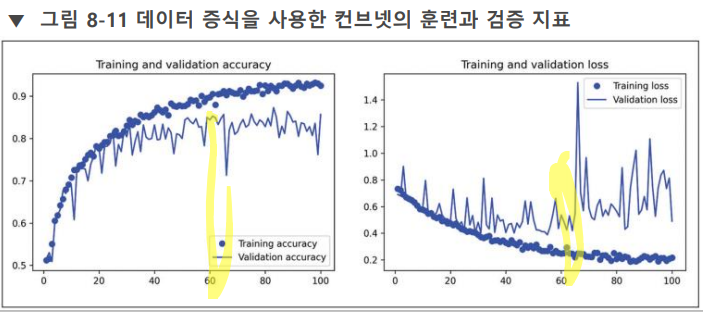

데이터 증식과 드롭아웃 덕분에 과대적합이 훨씬 늦은 60 ~ 70번째 에포크에서 시작된다 (원본은 10번째 에포크에서 시작된다)   
검증 정확도는 80~85% 유지

# 사전 훈련된 모델 활용하기
사전 훈련된 모델은 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련된 모델입니다.

사전 훈련된 모델을 사용하는 두가지 방법   
1. 특성 추출
2. 미세 조정

기존의 이미지와 클래스에 없는 새로운 이미지를 훈련하고자할 때, 기존에 훈련해둔 모델의 특성만 추출해서 새로운 이미지를 훈련할 때 사용한다.   
기존의 클래스가 아닌 새로운 클래스에 대한 학습에 사용하기 위해서 특성 추출을 사용한다.


In [3]:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False, # 상위층을 포함하지 않겠다는 의미
    input_shape=((180,180,3))
)

58889256/58889256 [==============================] - 0s 0us/step


weights - 모델을 초기화할 imagenet 가중치   
include_top = false: 상위층 신경망 제외 - 강아지와 고양이를 구분하는 밀집 연결 층을 훈련시키기 위함(이 모델을 차후 새로운 클래스로 학습할것이다)   
numpy형으로 all_features를 변환한 것. - 표준화된 표현

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

밀집 층이 없다.

# 두 가지의 방식이 가능하다.
1. 새로운 데이터 셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 저장한다.  그다음 밀집 연결 분류기의 입력으로 사용한다. (밀집 연결 분류기는 우리가 설정) 입력 이미지에 대해서 합성곱 기반 층을 한 번만 실행하면 되므로 비용이적지만 데이터 증식을 사용할 수 없다.

2. conv_base와 새로운 밀집 분류기를 연결한 모델을 만들고 엔드-투-엔드로 실행한다. 합성곱 기반층에 의해서 사전에 학습된 표현이 수정되는 것을 막기위해서 합성곱 기반 층을 동결한다.


# 데이터 증식을 사용하지 않는 빠른 특성 추출
## VGG 16 특성과 해당 레이블 추출하기\

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels=[]
    for images, labels in dataset:
        preprocessed_images= keras.applications.vgg16.preprocess_input(images)  # 스케일 조정
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

1. 스케일 조정을 한 데이터는 preprocessed_images이다
2. 해당 preprocessed_images의 특성을 추출하기 위해서 predict 함수를 사용한다.
3. 타입이 리스트인 all_features를 계산하기 편하고 표준화된 넘파이로 변환시킨다.
4. features 는 (5,5,512) 의 특성 추출값이며 이런 값이 2000개가 저장되어있는 변수가 all_features이다.


# 밀집 연결 분류기 정의하고 훈련하기


In [ ]:
inputs = keras.Input(shape=(5,5,512)) # 특성 추출 값이 (5,5,512)이라 입력으로 받기 위함
x = laters.Flatten()(inputs) # Dense층에 주입하기 전에 Flatten 층을 사용
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) # Dropout은 이전단계인 Dense(256)(x)에 적용됨
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only = True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data = (val_features, val_labels),
    callbacks=callbacks_module
)

# 데이터 증식을 사용한 특성 추출
1. conv_base와 새로운 밀집 분류기를 연결한다.
2. 합성곱 기반층을 동결한다. 사전에 학습된 표현이 합성곱 기반 층에 의해서 수정되는 것을 막기위해!

* 동결 한다는 것은 훈련하는 동안 가중치가 업데이트 되지 않도록 막는것이다.

## VGG16 합성곱 기반층 만들고 동결하기

In [ ]:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False, # 상위층을 포함하지 않겠다는 의미
    input_shape=((180,180,3))
)
conv_base.trainable = False # 합성곱 기반 층 동결!!!

# 데이터 증식 단계와 밀집 분류기를 합성곱 기반층에 추가하기
1. 데이트 증식
2. 동결된 합성곱 기반층
3. 밀집 분류기

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
]) # 데이터 증식

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs) # 데이터 증식 적용
x = keras.applications.vgg16.preprocess_input(x) # 입력값 스케일 조정
x = conv_base(x) # 동결된 합성곱 기반 층에 입력값 넣음
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

1. 동결된 합성곱 기반 층에 입력값을 넣어서 해당 출력값을 밀집 연결 분류기에 넣어준다. -> predict으로 특성 추출할 필요가 없다.